In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

Load Travis' table

In [2]:
tb = pd.read_csv("All_KepStars_For_Ruth_McQuillan_Analysis_grJHK.csv")
print(np.shape(tb))

(177039, 20)


In [3]:
tb.head()

,KIC,source_id,plx,plxe,g_final,g_final_err,g_prov_final,r_final,r_final_err,r_prov_final,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,[Fe/H]i,n_[Fe/H]i,_RA,_DE
0,757076,2050233807328471424,0.001524,0.000048,12.350957,0.020306,g_kic_fixed,11.588633,0.020419,r_kic_fixed,10.126,0.018,9.667,0.019,9.559,0.017,-0.083,KIC,291.03873,36.59813
1,757099,2050233601176543104,0.002708,0.000027,13.704047,0.020015,g_kis_fixed,13.115469,0.020004,r_kis_fixed,11.656,0.018,11.193,0.019,11.094,0.018,-0.208,KIC,291.04306,36.59381
2,757137,2050230543159814656,0.001753,0.000025,10.052258,0.027917,g_kic_fixed,9.099976,0.035228,r_kic_fixed,7.467,0.027,6.853,0.018,6.722,0.017,-0.079,KIC,291.05588,36.55995
3,757280,2050230611879323904,0.001214,0.000022,12.132906,0.020044,g_kic_fixed,11.825413,0.020076,r_kic_fixed,10.852,0.018,10.662,0.018,10.627,0.018,-0.231,KIC,291.09540,36.56494
4,757450,2050231848829944320,0.001199,0.000026,15.894970,0.020246,g_kis_fixed,15.152545,0.020081,r_kis_fixed,13.665,0.021,13.262,0.025,13.118,0.029,0.229,SPE,291.13760,36.57738


Crossmatch with the McQuillan catalogue.

In [4]:
url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)
mc.head()

,KID,Teff,logg,Mass,Prot,Prot_err,Rper,LPH,w,DC,Flag
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,---
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,---
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,---
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,---
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,---


In [5]:
print(np.shape(mc))

(34030, 11)


In [6]:
mctb1 = pd.merge(tb, mc, left_on="KIC", right_on="KID", how="inner")
print(np.shape(tb), np.shape(mc), np.shape(mctb1))

(177039, 20) (34030, 11) (30086, 31)


Add Teffs from Travis' catalog.

In [7]:
with fits.open("hlsp_kg-radii_kepler-gaia_multi_all_multi_v1_star-cat.fits") as data:
    tb2 = pd.DataFrame(data[1].data, dtype="float64")
    
tb_teff = pd.DataFrame(dict({"berger_teff": tb2.Teff, "berger_teff_err": tb2.Teff_err,
                             "KIC": tb2.KIC_ID}))

In [8]:
mctb = pd.merge(mctb1, tb_teff, left_on="KID", right_on="KIC", how="inner")
print(np.shape(mctb), np.shape(mctb1), np.shape(tb_teff))

(30044, 34) (30086, 31) (177911, 3)


Calculate Av

In [9]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 23.578 s
  pix_info:   0.509 s
   samples:  11.409 s
      best:   5.233 s
       nan:   0.059 s
      sort:   6.124 s
       idx:   0.245 s


In [10]:
coords = SkyCoord(mctb._RA.values*units.deg, mctb._DE.values*units.deg,
                  distance=(1./mctb.plx.values)*units.pc, frame='galactic')

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.], return_flags=True)

In [11]:
Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)
print(np.shape(mctb), np.shape(Av))

# Catch places where the extinction uncertainty is zero and default to an uncertainty of .05
m = Av_std == 0
Av_std[m] = .05

(30044, 34) (30044,)


In [12]:
# mctb["Av_flags"] = flags
mctb["Av"] = Av
mctb["Av_errp"] = Av_errp
mctb["Av_errm"] = Av_errm
mctb["Av_std"] = Av_std

Remove NaNs.

In [13]:
def mM(m, D):
    return 5 - 5*np.log10(D) + m

m = np.isfinite(mctb.g_final.values - mctb.Kmag.values)
m &= np.isfinite(mM(mctb.g_final.values, 1./mctb.plx.values))
m &= np.isfinite(mctb.Av.values) * np.isfinite(mctb.Av_errp.values)
m &= np.isfinite(mctb.Av_errm.values) * np.isfinite(mctb.Av_std.values)

mctb["abs_g"] = mM(mctb.g_final, 1./mctb.plx)

df_finite = mctb.iloc[m]

Download Gaia catalog

In [14]:
# import astropy.utils as au
# from astropy.io import fits

# gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

# with fits.open(gaia_url) as data:
#     gaia = pd.DataFrame(data[1].data, dtype="float64")

Merge the Gaia catalog and the McQuillan sample.

In [15]:
# gaia_df = pd.merge(mctb, gaia, left_on="KID", right_on="kepid", how="inner")
# print(np.shape(mctb), np.shape(gaia), np.shape(gaia_df))

Plot stars on the CMD.

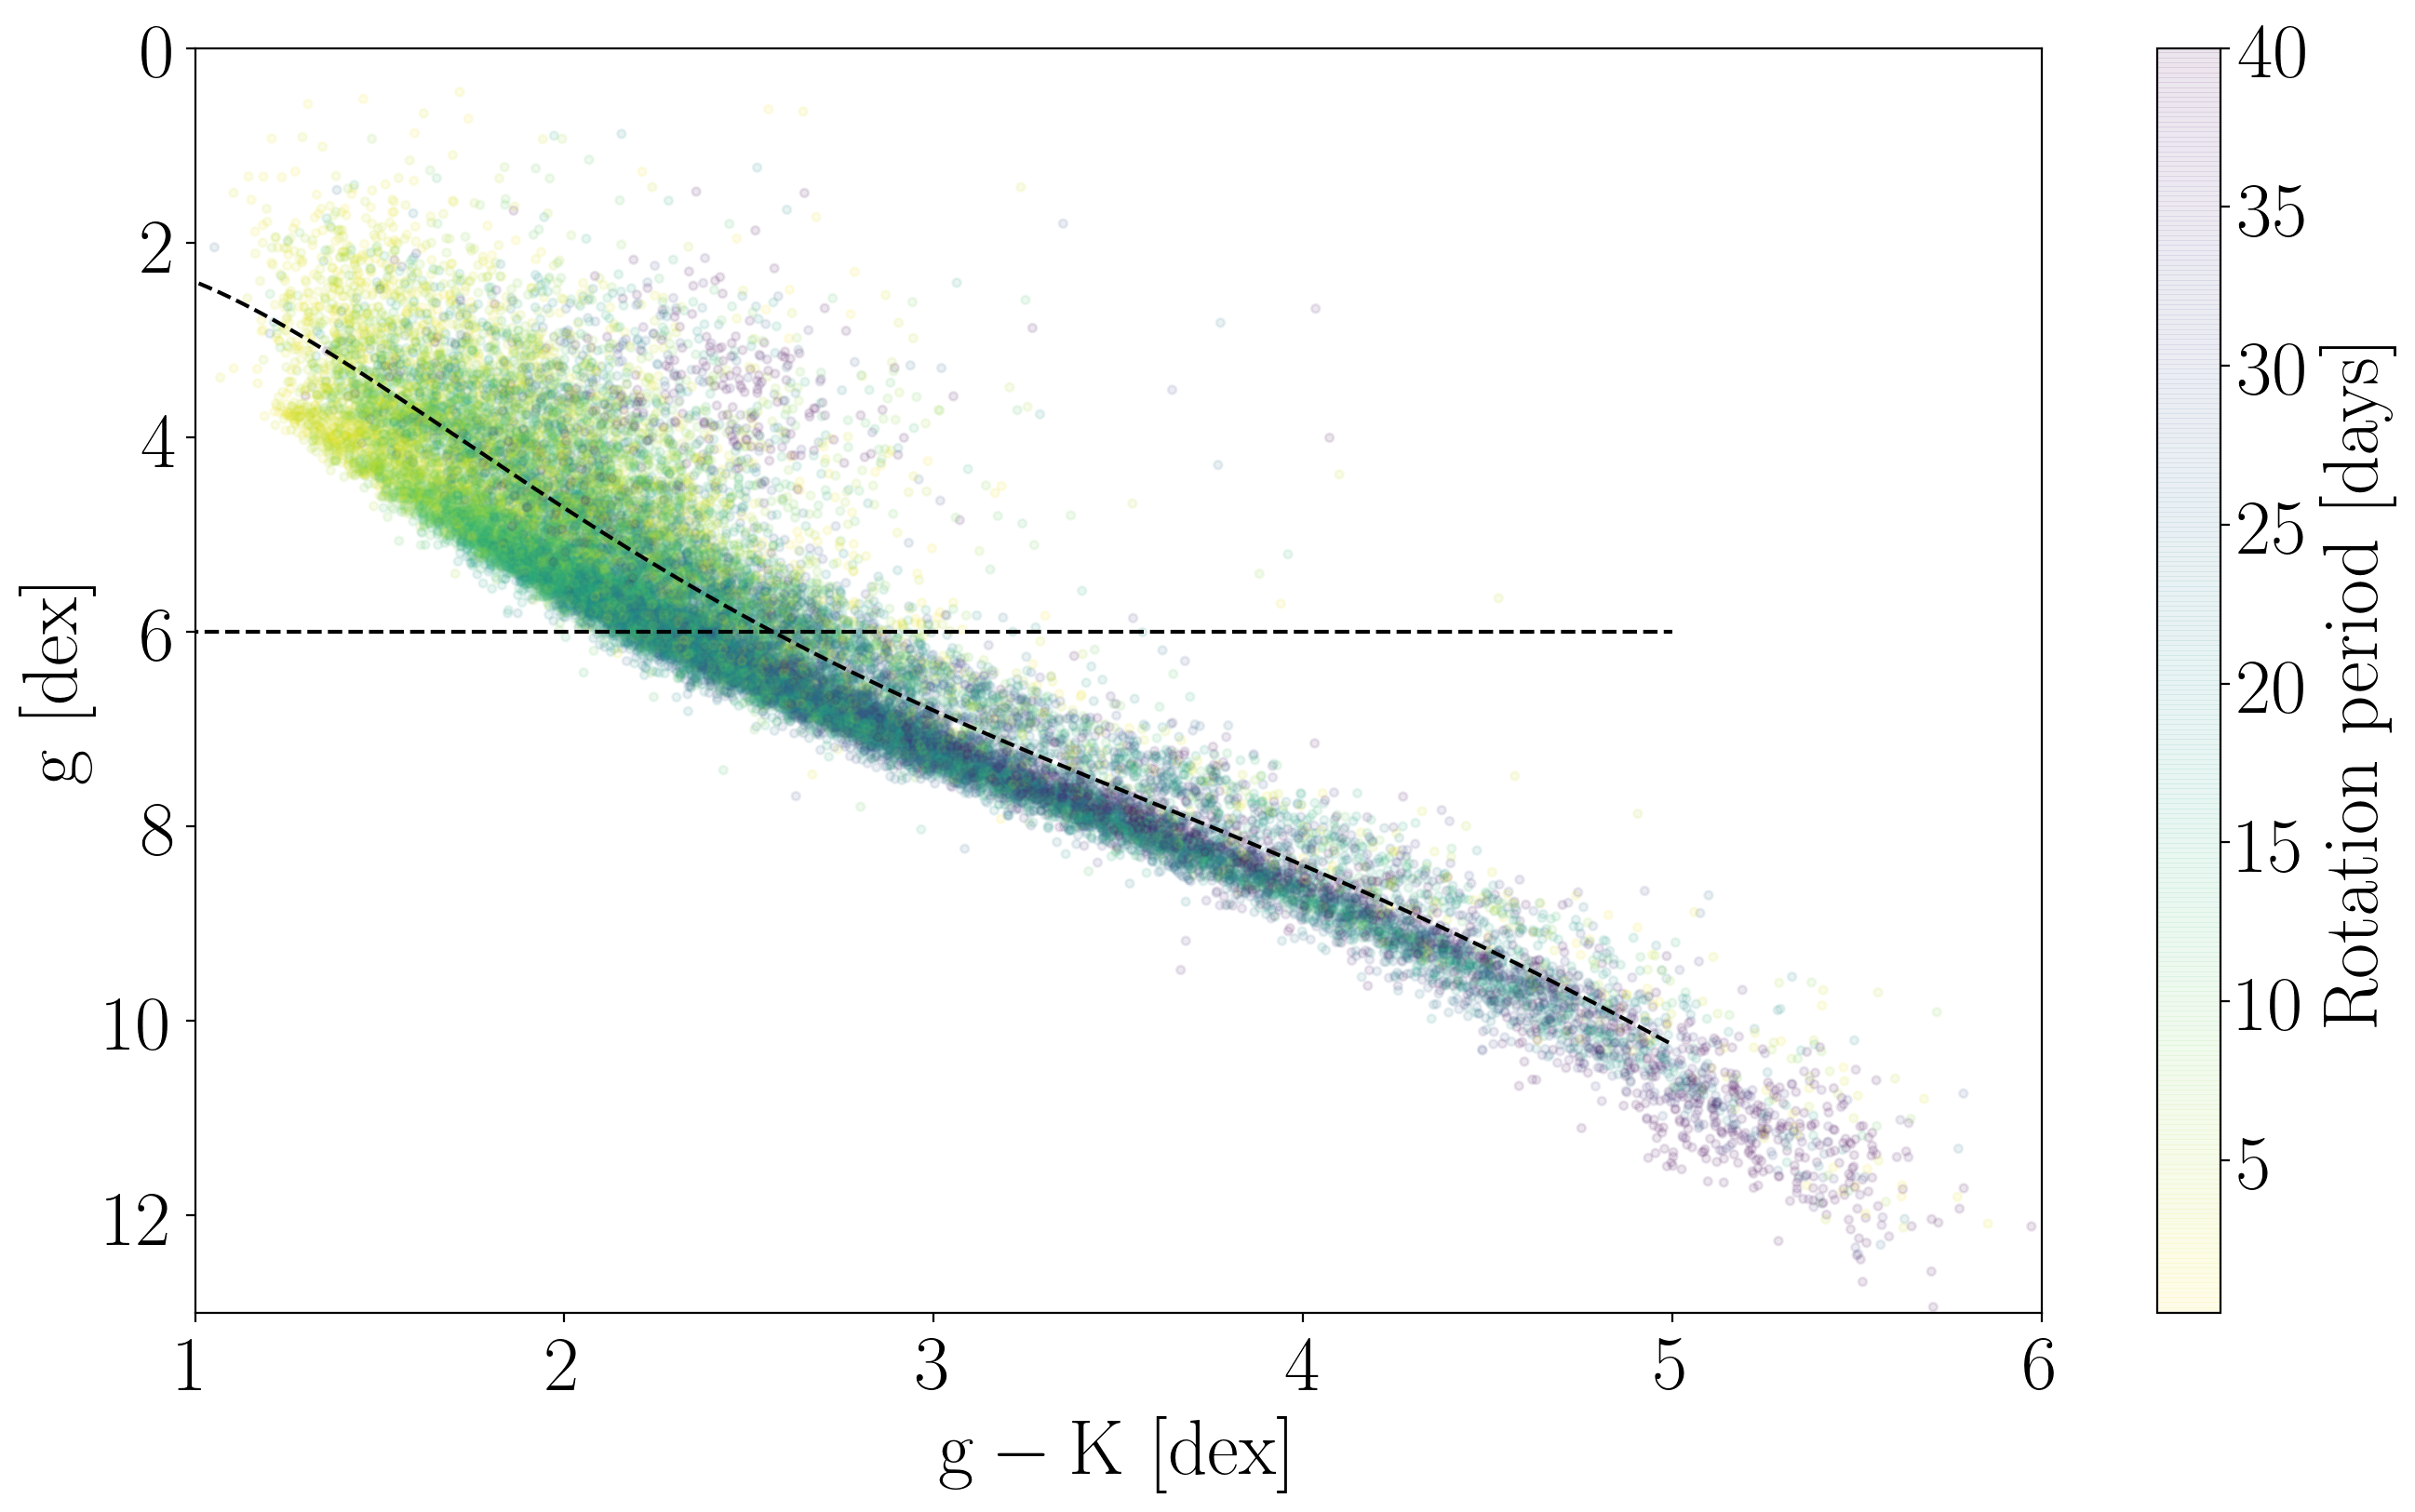

In [16]:
import scipy.optimize as spo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)


plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df_finite.g_final - df_finite.Kmag, mM(df_finite.g_final, 1./df_finite.plx),
            c=df_finite.Prot, s=10, alpha=.1, cmap="viridis_r", vmax=40, rasterized=True)
plt.xlabel("$\mathrm{g-K~[dex]}$")
plt.ylabel("$\mathrm{g~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(13, 0)
plt.xlim(1, 6);

x = df_finite.g_final.values - df_finite.Kmag.values
y = mM(df_finite.g_final.values, 1./df_finite.plx.values)

AT = np.vstack((x**6, x**5, x**4, x**3, x**2, x, np.ones_like(x)))
ATA = np.dot(AT, AT.T)
w = np.linalg.solve(ATA, np.dot(AT, y))

minb, maxb, extra = 0, 5, .15
xs = np.linspace(minb, maxb, 1000)
plt.plot(xs, np.polyval(w, xs) - extra, "k--")
plt.plot(xs, np.ones_like(xs)*6, "k--")
plt.savefig("paper/CMD_cuts.pdf")

In [17]:
# import read_mist_models
# iso = read_mist_models.ISO(
#     "/Users/rangus/projects/astro-viz/data/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso")

Load isochrones

In [18]:
# from tqdm import tqdm
# ages, G, bp, rp = [[] for i in range(4)]
# for i, a in enumerate(tqdm(np.log10(np.linspace(.1, 13.8, 100)*1e9))):
    
#     age_ind = iso.age_index(a) #returns the index for the desired age
#     age = (10**iso.isos[age_ind]["log10_isochrone_age_yr"])*1e-9
#     g = iso.isos[age_ind]["Gaia_G_DR2Rev"]
#     _rp = iso.isos[age_ind]["Gaia_RP_DR2Rev"]
#     _bp = iso.isos[age_ind]["Gaia_BP_DR2Rev"]
    
#     ages.append(age)
#     G.append(g)
#     rp.append(_rp)
#     bp.append(_bp)

# ages = np.array([i for j in ages for i in j])
# G = np.array([i for j in G for i in j])
# bp = np.array([i for j in bp for i in j])
# rp = np.array([i for j in rp for i in j])

In [19]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.scatter(gaia_df.phot_bp_mean_mag - gaia_df.phot_rp_mean_mag,
#             mM(gaia_df.phot_g_mean_mag, 1./gaia_df.plx),
#             c=gaia_df.Prot, s=10, alpha=.1, cmap="viridis_r", vmax=40, rasterized=True)
# plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
# plt.ylabel("$\mathrm{g~[dex]}$")
# plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
# plt.ylim(13, 0)
# plt.xlim(0, 3)

# plt.plot(bp-rp, G)

In [20]:
# gk, abs_g = df_finite.g_final - df_finite.Kmag, mM(df_finite.g_final, 1./df_finite.plx)
# m = (gk > 3) * (gk < 4)

# plt.scatter(gk[m], abs_g[m] - np.polyval(w, gk[m]),
#             c=df_finite.Prot[m], s=10, alpha=.1, cmap="viridis_r", vmax=40, rasterized=True)
# plt.xlabel("$\mathrm{g-K~[dex]}$")
# plt.ylabel("$\mathrm{g~[dex]}$")
# plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
# plt.ylim(1, -1.5)

In [21]:
# plt.figure(figsize=(16, 9))
# plt.hist(abs_g[m] - np.polyval(w, gk[m]), 800);
# plt.xlim(1.5, -2)
# plt.xlabel("$\Delta~g~\mathrm{[dex]}$")

Calc abs mag

In [22]:
abs_g = mM(df_finite.g_final[m], 1./df_finite.plx[m])
df_finite["abs_g"] = abs_g

Cut out the binaries

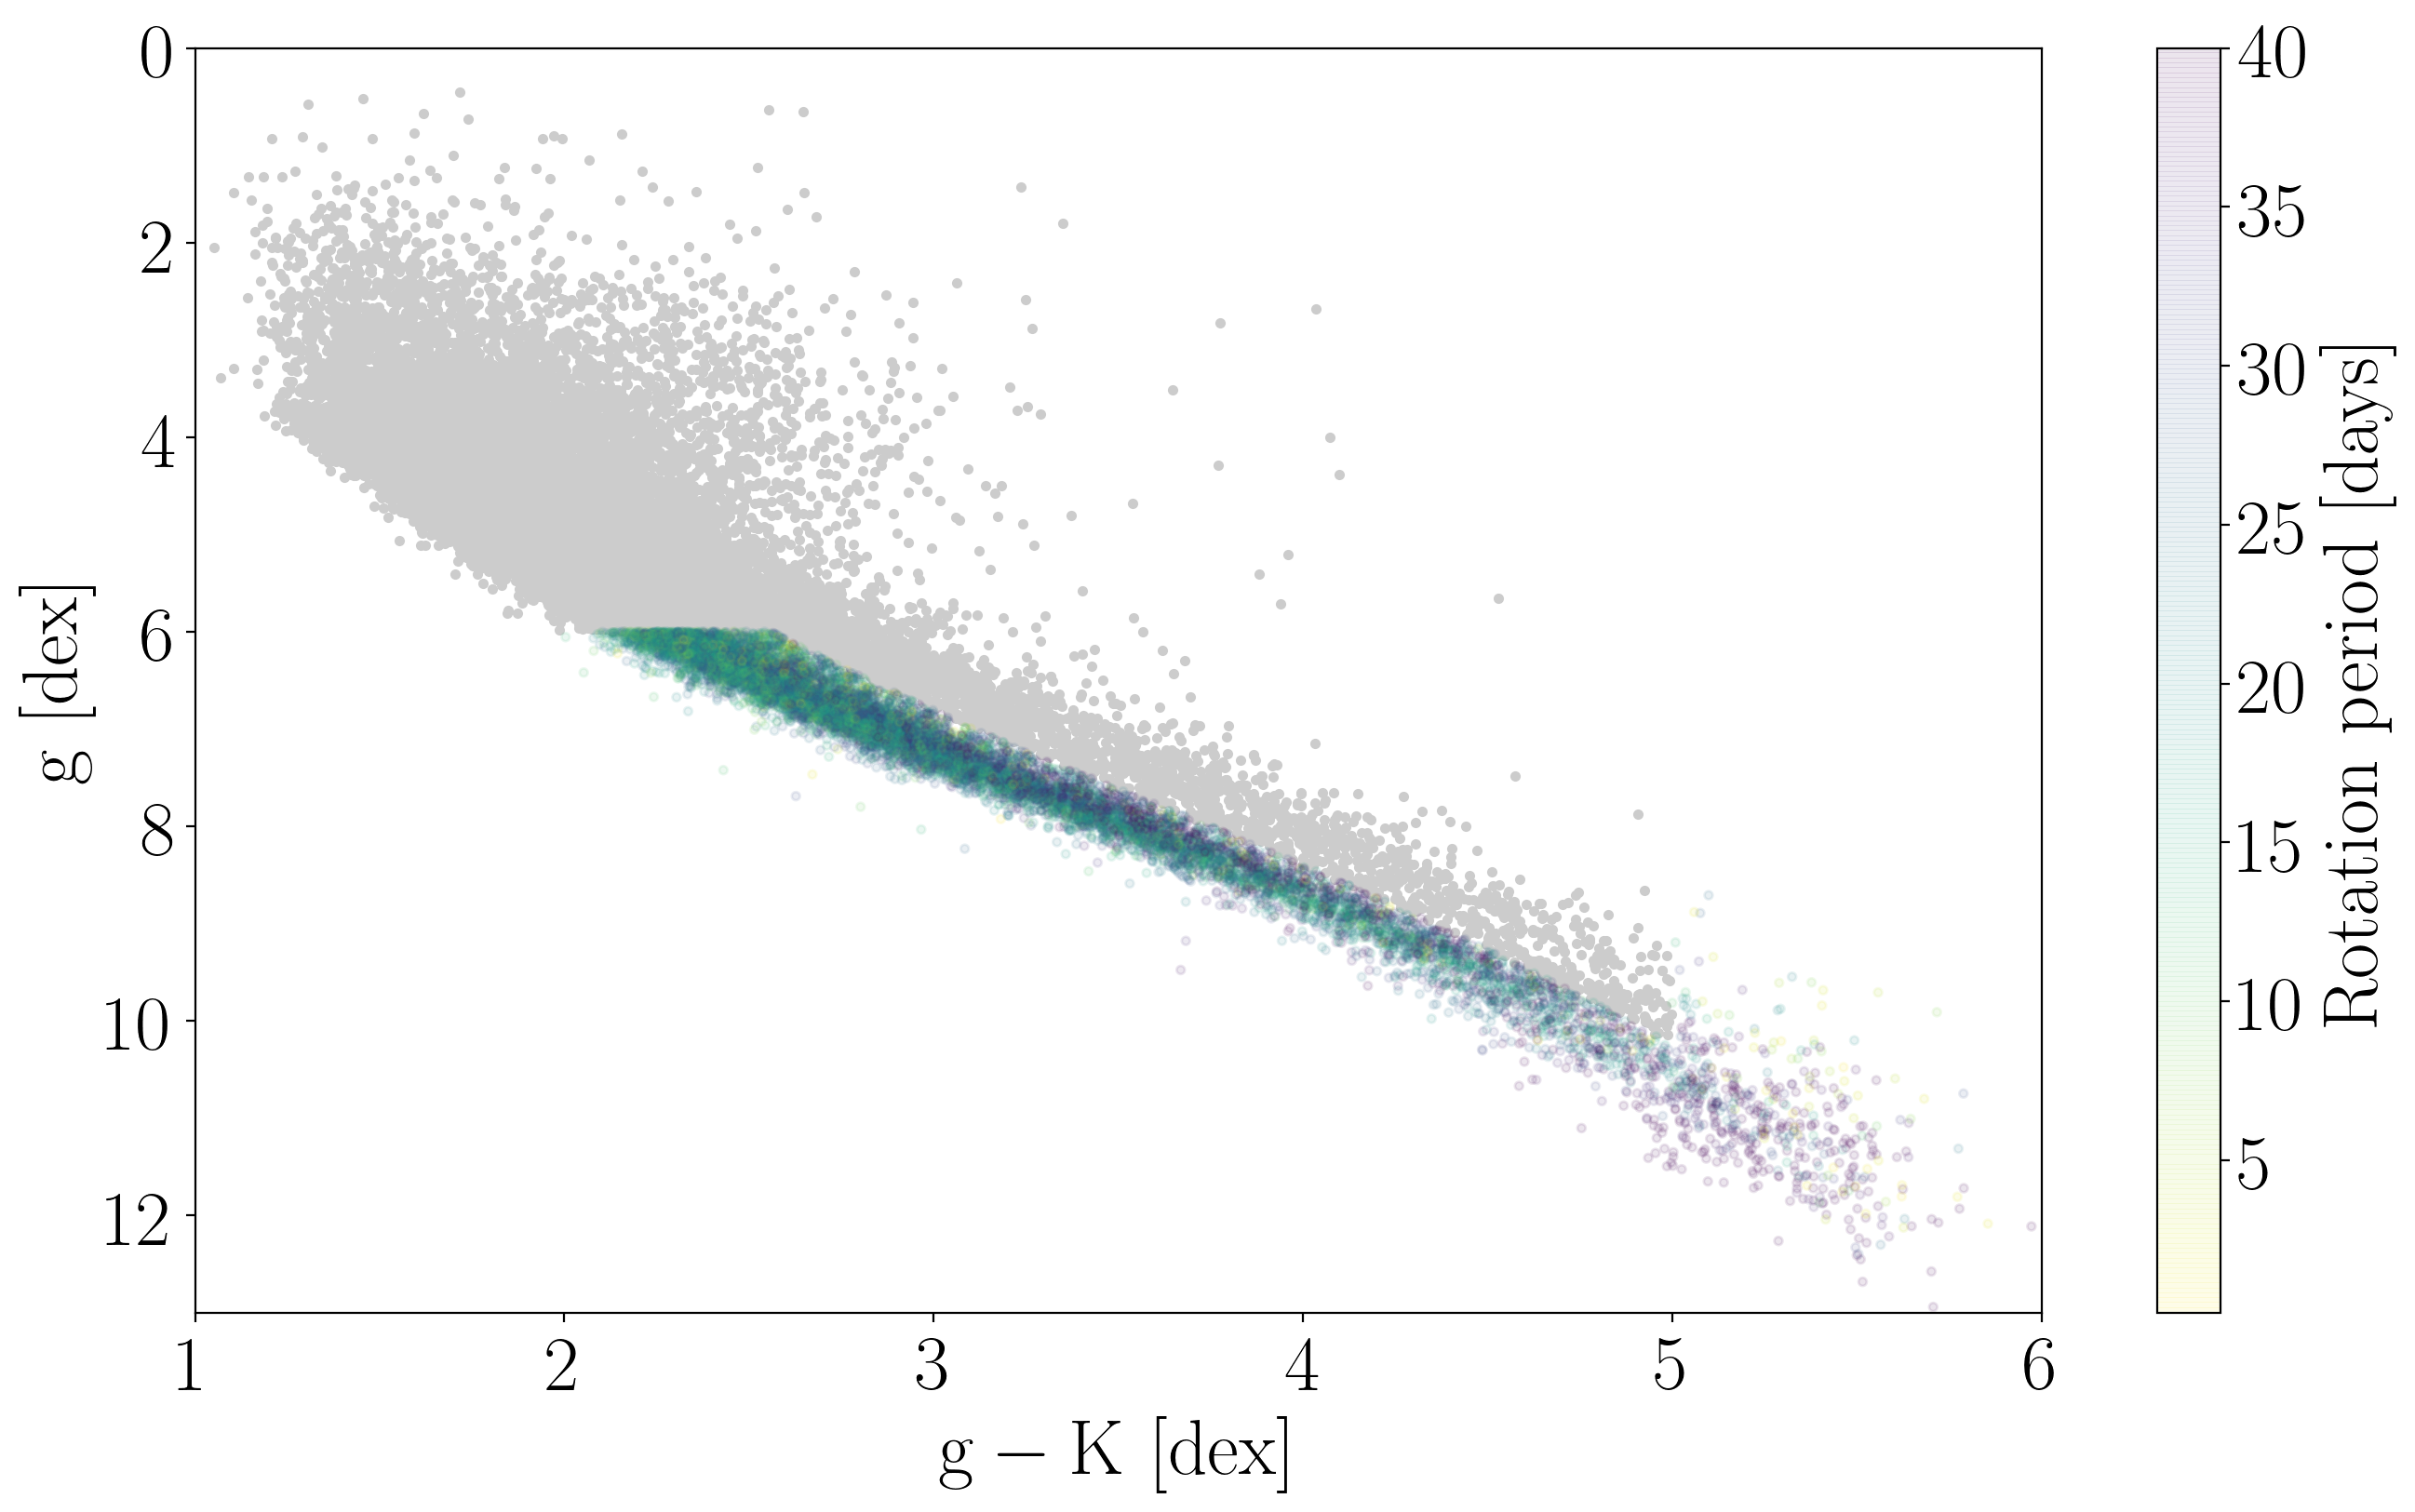

In [23]:
m = (minb < x) * (x < maxb)
m &= (y < np.polyval(w, x) - extra) + (6 > y)

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(df_finite.g_final[m] - df_finite.Kmag[m], 
         mM(df_finite.g_final[m], 1./df_finite.plx[m]),
         ".", c=".8", zorder=0)
# plt.scatter(df_finite.g_final[m] - df_finite.Kmag[m],
#             mM(df_finite.g_final[m], 1./df_finite.plx[m]),
#             c=df_finite.Prot[m], s=10, alpha=.03, cmap="viridis_r", vmax=40, zorder=1)
plt.scatter(df_finite.g_final[~m] - df_finite.Kmag[~m],
            mM(df_finite.g_final[~m], 1./df_finite.plx[~m]),
            c=df_finite.Prot[~m], s=10, alpha=.1, cmap="viridis_r", vmax=40, zorder=1)
plt.xlabel("$\mathrm{g-K~[dex]}$")
plt.ylabel("$\mathrm{g~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(13, 0)
plt.xlim(1, 6);

Flag is zero for subgiants and visual binaries, one for single stars.

In [24]:
flag = np.zeros(len(df_finite))
flag[~m] = np.ones(len(flag[~m])) 
df_finite["flag"] = flag

In [25]:
df = df_finite.iloc[~m]
df.to_csv("single_MS_stars.csv")

Download Gaia catalog

In [26]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

Merge the Gaia catalog and the McQuillan sample.

In [27]:
gaia_mc = pd.merge(df, gaia, left_on="KID", right_on="kepid", how="inner")
print(np.shape(mc), np.shape(gaia), np.shape(gaia_mc))

(34030, 11) (197090, 101) (12673, 141)


Calculate very simple gyro ages for these stars.

In [28]:
from stardate.lhf import age_model

logages = []
for i, p in enumerate(gaia_mc.Prot.values):
    logages.append(age_model(np.log10(p),gaia_mc.phot_bp_mean_mag.values[i] -
                             gaia_mc.phot_rp_mean_mag.values[i]))

gaia_mc["log_age"] = np.array(logages)
gaia_mc["age"] = (10**np.array(logages))*1e-9

Plot all McQuillan single dwarfs.

(34030, 11)


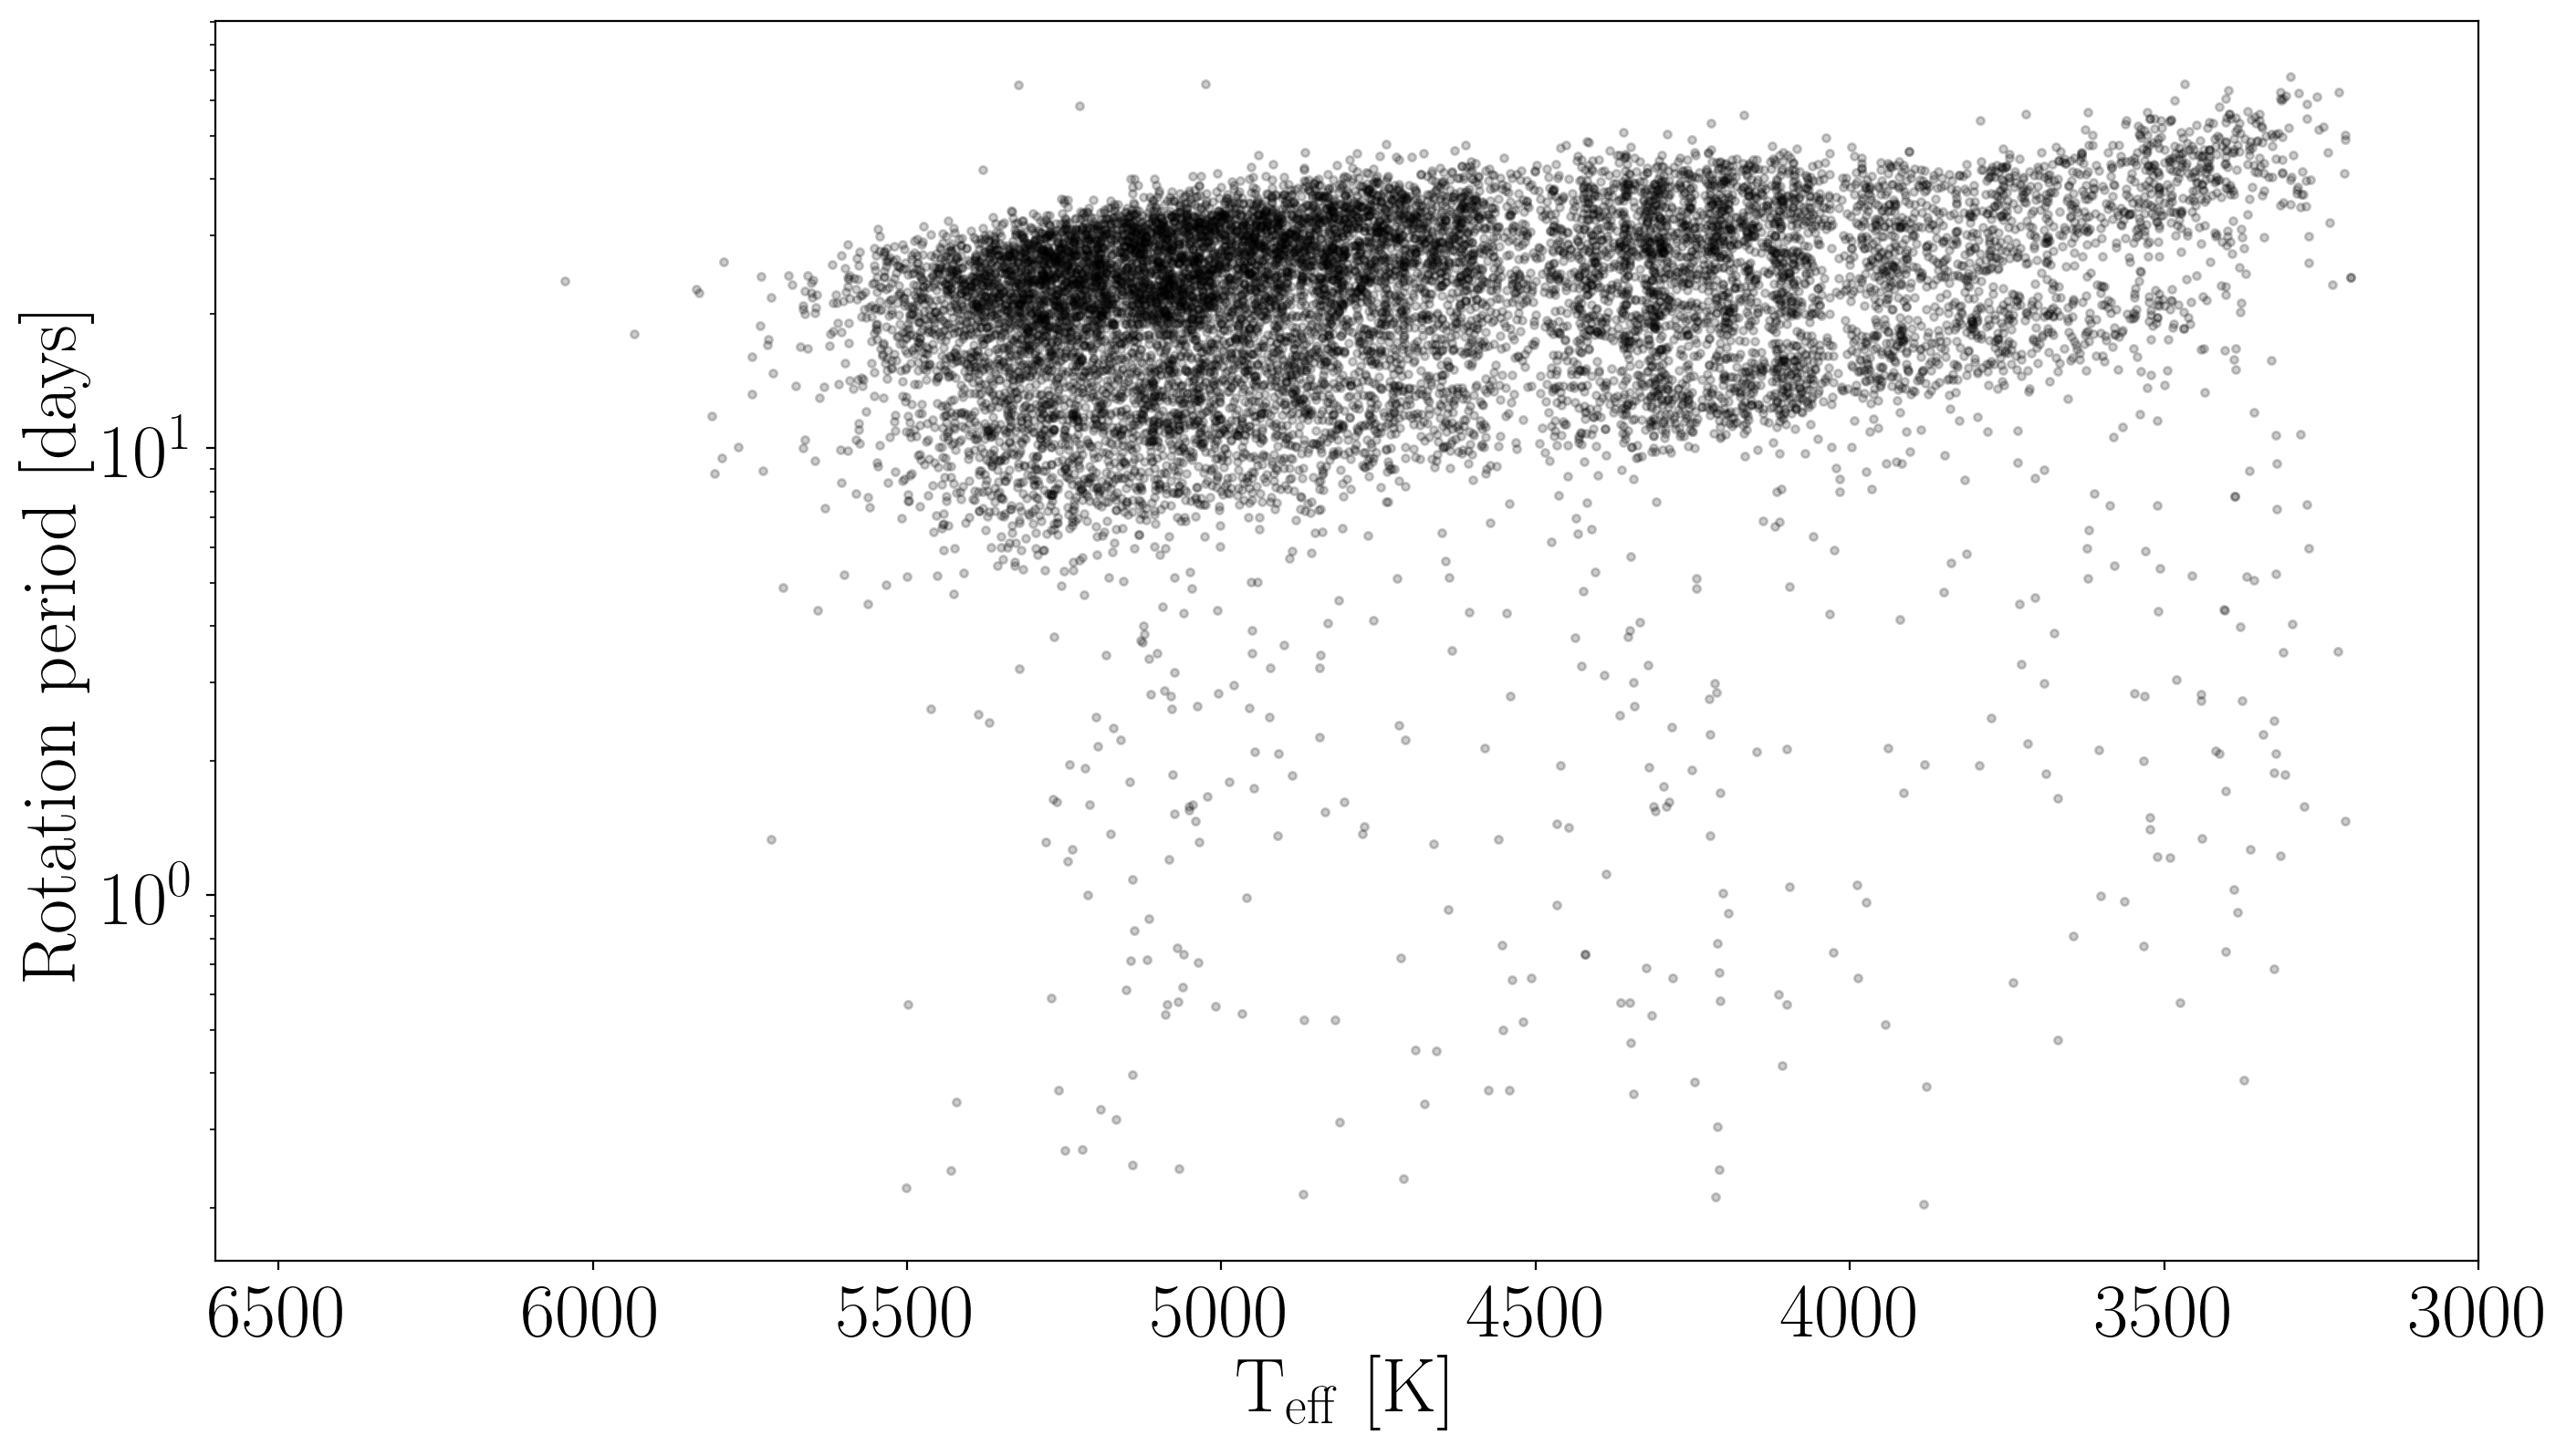

In [29]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gaia_mc.Teff, gaia_mc.Prot, "k.", alpha=.2, zorder=0, rasterized=True)
plt.xlim(6600, 3000)
plt.yscale("log")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");
plt.savefig("paper/the_gap.pdf")
print(np.shape(mc))

Cut out stars with negative parallax and stars with low signal-to-noise.

In [30]:
m = gaia_mc.parallax.values > 0.
m &= gaia_mc.parallax.values/gaia_mc.parallax_error.values > 10.
gaia_mc = gaia_mc.iloc[m]

# m = gaia_mc.Teff.values < 4800
# gaia_mc_cool = gaia_mc.iloc[m]
# gaia_mc_hot = gaia_mc.iloc[~m]

Calculate velocities.

In [31]:
from calc_velocities import calc_vb

pmb_samples, vb_samples = calc_vb(gaia_mc)
print(np.shape(pmb_samples))

(12632, 1000)


In [32]:
print(np.shape(vb_samples))
print(vb_samples[0, 0])

(12632, 1000)
-0.9257564782365716


In [33]:
pmb, vb = np.median(pmb_samples, axis=1), np.median(vb_samples, axis=1)
pmb_err, vb_err = np.std(pmb_samples, axis=1), np.std(vb_samples, axis=1)
pmb_errp = np.percentile(pmb_samples, 84, axis=1) - pmb
pmb_errm = pmb - np.percentile(pmb_samples, 16, axis=1)
vb_errp = np.percentile(vb_samples, 84, axis=1) - vb
vb_errm = vb - np.percentile(vb_samples, 16, axis=1)

In [35]:
gaia_mc["vb"] = vb
gaia_mc["vb_err"] = vb_err

In [36]:
# import astropy.units as u
# from astropy.coordinates import ICRS
# from astropy.coordinates import Galactic

# i = 0
# icrs = ICRS(ra=gaia_mc.ra.values*u.degree,
#             dec=gaia_mc.dec.values*u.degree,
#             distance=1./(gaia_mc.parallax.values*1e-3)*u.pc,
#             pm_ra_cosdec=gaia_mc.pmra.values*u.mas/u.yr,
#             pm_dec=gaia_mc.pmdec.values*u.mas/u.yr)
# vels = icrs.transform_to(Galactic)
# print(vels)
# # vels.pm_b
# # pm_b = np.array(vels.pm_b.value)
# # gaia_mc_cool["pm_b"] = pm_b

Calculate v_ra, v_dec and v_b

In [37]:
import astropy.coordinates as coord
import astropy.units as u
d = coord.Distance(parallax=gaia_mc.parallax.values * u.mas)
vra = (gaia_mc.pmra.values*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
vdec = (gaia_mc.pmdec.values*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())

c = coord.SkyCoord(ra=gaia_mc.ra.values*u.deg, dec=gaia_mc.dec.values*u.deg, distance=d, 
                   pm_ra_cosdec=gaia_mc.pmra.values*u.mas/u.yr,
                   pm_dec=gaia_mc.pmdec.values*u.mas/u.yr)
gal = c.galactic
v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles())

gaia_mc["v_b"] = v_b.value
gaia_mc["v_ra"] = vra.value
gaia_mc["v_dec"] = vdec.value

Calculate actions for stars with RVs.

In [38]:
mrv = gaia_mc.radial_velocity.values != 0.00
print(len(gaia_mc.radial_velocity[mrv]), "stars in McQuillan with Gaia RVs")

487 stars in McQuillan with Gaia RVs


In [39]:
import actions as ac
from tqdm import trange

jz = np.ones(len(gaia_mc.ra.values))*np.nan
for i in trange(len(gaia_mc.ra.values)):
    if gaia_mc.radial_velocity.values[i] != 0.00:
        try:
            R_kpc, phi_rad, z_kpc, vR_kms, vT_kms, vz_kms, jR, Lz, Jz = ac.action(
                gaia_mc.ra.values[i], gaia_mc.dec.values[i],
                1./gaia_mc.parallax.values[i], 
                gaia_mc.pmra.values[i], gaia_mc.pmdec.values[i],
                gaia_mc.radial_velocity.values[i])
            jz[i] = Jz
        except:
            UnboundError

gaia_mc["jz"] = jz

  0%|          | 41/12632 [00:00<00:31, 393.87it/s]

100%|██████████| 12632/12632 [00:25<00:00, 494.55it/s]


Still to do: calculate action uncertainties, e.g.:

In [40]:
# def action_with_err(ra_dec, dec_deg, parallax_mas, pmra_masyr, pmdec_masyr, rv_kms, rv_err, cov):
#     """
#     Calculate actions with uncertainties, given a covariance matrix.
    
#     Args:
#         ra_deg
#         dec_deg
#         parallax_mas
#         pmra_masyr
#         pmdec_masyr
#         rv_kms
#         rv_err
#         cov
        
#     cov = [[ra_err**2        ra_dec_corr       ra_parallax_corr    ra_pmra_corr       ra_pmdec_corr]
#            [ra_dec_corr      dec_err**2        dec_parallax_corr   dec_pmra_corr      dec_pmdec_corr]
#            [ra_parallax_corr dec_parallax_corr parallax_err**2     parallax_pmra_corr parallax_pmdec_corr]
#            [ra_pmra_corr     dec_pmra_corr     parallax_pmra_corr  pmra_err**2        pmra_pmdec_corr]
#            [ra_pmdec_corr    dec_pmdec_corr    parallax_pmdec_corr pmra_pmdec_corr    pmdec_err**2]]
#     """

Save Gaia-Mcquillan crossmatch with velocities to csv.

In [41]:
gaia_mc.to_csv("gaia_mc.csv")

Now cut on temperature and save.

In [42]:
m = gaia_mc.Teff.values < 4800
gaia_mc_cool = gaia_mc.iloc[m]

In [43]:
gaia_mc_cool.to_csv("gaia_mc_cool.csv")

In [44]:
np.shape(gaia_mc_cool)

(5845, 149)

(4800, 3200)

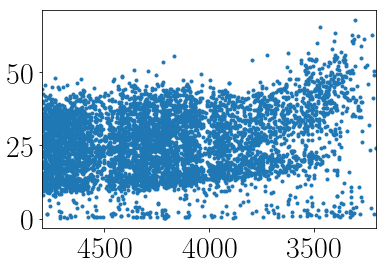

In [231]:
plt.plot(gaia_mc_cool.Teff, gaia_mc_cool.Prot, ".")
plt.xlim(4800, 3200)

If you want to make this smaller, the Gaia columns to keep are:

In [ ]:
mini_gaia = pd.DataFrame(dict({"source_id": gaia.source_id,
                               "kepid": gaia.kepid,
                               "ra": gaia.ra, "ra_error": gaia.ra_error,
                               "dec": gaia.dec, "dec_error": gaia.dec_error,
                               "parallax": gaia.parallax,
                               "parallax_error": gaia.parallax_error,
                               "pmra": gaia.pmra, "pmra_error": gaia.pmra_error,
                               "pmdec": gaia.pmdec, "pmdec_error": gaia.pmdec_error,
                               "ra_dec_corr": gaia.ra_dec_corr,
                               "ra_parallax_corr": gaia.ra_parallax_corr,
                               "ra_pmra_corr": gaia.ra_pmra_corr,
                               "ra_pmdec_corr": gaia.ra_pmdec_corr,
                               "dec_parallax_corr": gaia.dec_parallax_corr,
                               "dec_pmra_corr": gaia.dec_pmra_corr,
                               "dec_pmdec_corr": gaia.dec_pmdec_corr,
                               "parallax_pmra_corr": gaia.parallax_pmra_corr,
                               "parallax_pmdec_corr": gaia.parallax_pmdec_corr,
                               "pmra_pmdec_corr": gaia.pmra_pmdec_corr,
                               "radial_velocity": gaia.radial_velocity,
                               "radial_velocity_error": gaia.radial_velocity_error,
                               "G": gaia.phot_g_mean_mag,
                               "bp": gaia.phot_bp_mean_mag,
                               "rp": gaia.phot_rp_mean_mag,
                               "jmag": gaia.jmag,
                               "hmag": gaia.hmag,
                               "kmag": gaia.kmag
                              }))

In [118]:
tb.head()

,KIC,source_id,plx,plxe,g_final,g_final_err,g_prov_final,r_final,r_final_err,r_prov_final,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,[Fe/H]i,n_[Fe/H]i,_RA,_DE
0,757076,2050233807328471424,0.001524,0.000048,12.350957,0.020306,g_kic_fixed,11.588633,0.020419,r_kic_fixed,10.126,0.018,9.667,0.019,9.559,0.017,-0.083,KIC,291.03873,36.59813
1,757099,2050233601176543104,0.002708,0.000027,13.704047,0.020015,g_kis_fixed,13.115469,0.020004,r_kis_fixed,11.656,0.018,11.193,0.019,11.094,0.018,-0.208,KIC,291.04306,36.59381
2,757137,2050230543159814656,0.001753,0.000025,10.052258,0.027917,g_kic_fixed,9.099976,0.035228,r_kic_fixed,7.467,0.027,6.853,0.018,6.722,0.017,-0.079,KIC,291.05588,36.55995
3,757280,2050230611879323904,0.001214,0.000022,12.132906,0.020044,g_kic_fixed,11.825413,0.020076,r_kic_fixed,10.852,0.018,10.662,0.018,10.627,0.018,-0.231,KIC,291.09540,36.56494
4,757450,2050231848829944320,0.001199,0.000026,15.894970,0.020246,g_kis_fixed,15.152545,0.020081,r_kis_fixed,13.665,0.021,13.262,0.025,13.118,0.029,0.229,SPE,291.13760,36.57738


Let's try running stardate on one of these stars.

In [34]:
import stardate as sd

Only use metallicities if they're spectroscopic.

In [35]:
i = 0
if df["n_[Fe/H]i"].values[i] == "SPE":
    iso_params = {"g": (df.g_final.values[i], df.g_final_err.values[i]),
                  "r": (df.r_final.values[i], df.r_final_err.values[i]),
                  "J": (df.Jmag.values[i], df.e_Jmag.values[i]),
                  "H": (df.Hmag.values[i], df.e_Hmag.values[i]),
                  "K": (df.Kmag.values[i], df.e_Kmag.values[i]),
                  "feh": (df["[Fe/H]i"].values[i], .05),
                  "parallax": (df.plx[i].values*1e3, df.plxe.values[i]*1e3)}
else:
    iso_params = {"g": (df.g_final.values[i], df.g_final_err.values[i]),
                  "r": (df.r_final.values[i], df.r_final_err.values[i]),
                  "J": (df.Jmag.values[i], df.e_Jmag.values[i]),
                  "H": (df.Hmag.values[i], df.e_Hmag.values[i]),
                  "K": (df.Kmag.values[i], df.e_Kmag.values[i]),
                  "parallax": (df.plx.values[i]*1e3, df.plxe.values[i]*1e3)}
    
print(iso_params)
print(df.Prot.values[i], df.Av.values[i], df.Av_errm.values[i])

prot, prot_err = df.Prot.values[i], df.Prot.values[i]*.05
star = sd.Star(iso_params, prot=prot, prot_err=prot_err,
               Av=df.Av.values[i], Av_err=df.Av_std.values[i],
               savedir="posteriors", filename="test")

{'g': (16.087088578099998, 0.0203150148217), 'r': (15.2187902098, 0.020088848135900002), 'J': (13.652000000000001, 0.026000000000000002), 'H': (13.099, 0.025), 'K': (13.003, 0.026000000000000002), 'parallax': (1.7670000000000001, 0.0248)}
13.765 0.23306999223679303 0.00932279805511238


In [36]:
star.fit(max_n=10000, thin_by=100)

100%|██████████| 10000/10000 [01:38<00:00, 101.14it/s]


In [37]:
from stardate import load_samples, read_samples

# Load the samples.
flatsamples, samples, prior_samples, posterior_samples = load_samples("posteriors/test.h5", burnin=50)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)

# Print the results as a pandas dataframe.
results

,EEP_med,EEP_errm,EEP_errp,EEP_std,EEP_ml,age_med_gyr,age_errm,age_errp,age_std,age_ml_gyr,...,distance_errm,distance_errp,distance_std_pc,distance_ml,Av_med,Av_errm,Av_errp,Av_std,Av_ml,index
0,281.692558,3.059793,3.2398,8.310309,281.140365,0.972628,0.08027,0.093708,0.58478,0.959946,...,8.033859,7.998642,21.331033,564.919469,0.232051,0.01011,0.010078,0.011117,0.23126,0


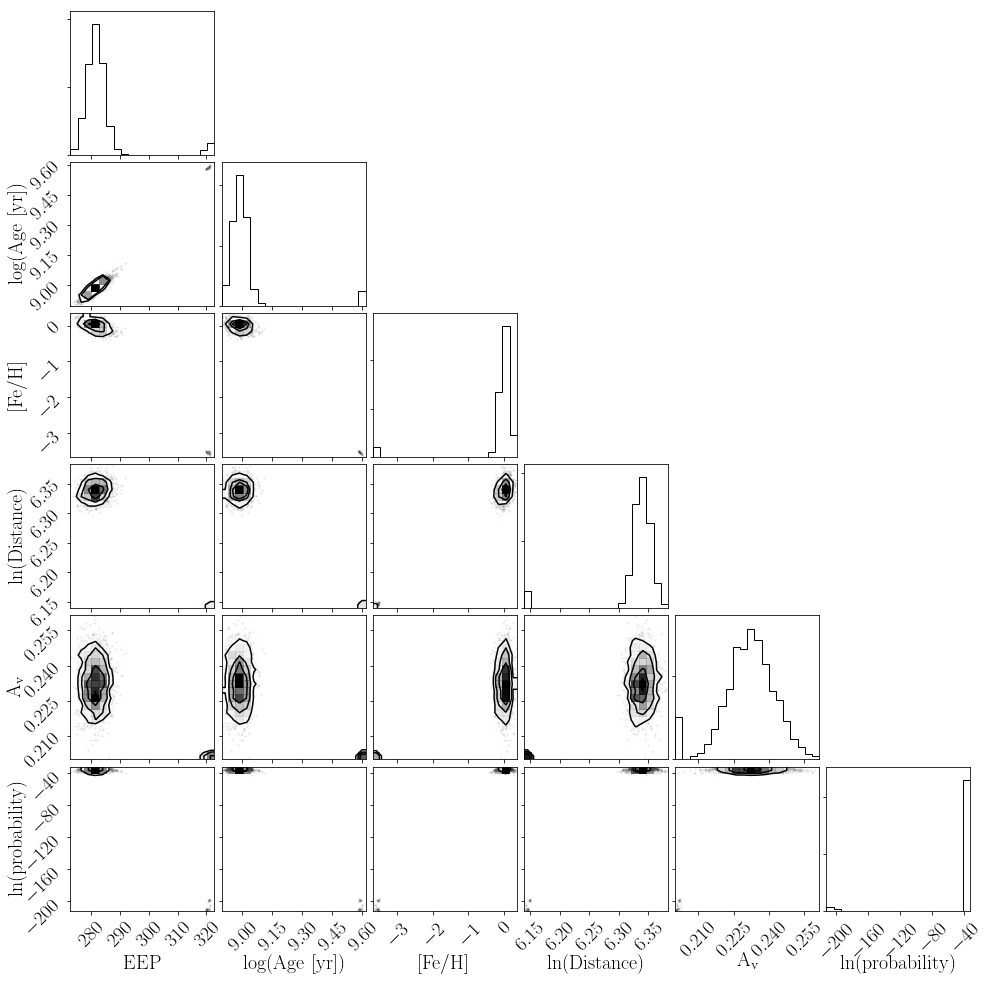

In [38]:
import corner

plotpar = {'axes.labelsize': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20}
plt.rcParams.update(plotpar)

labels = ["$\mathrm{EEP}$", "$\mathrm{log(Age~[yr])}$", 
          "$\mathrm{[Fe/H]}$", "$\mathrm{ln(Distance)}$",
          "$\mathrm{A_v}$", "$\mathrm{ln(probability)}$"]

corner.corner(flatsamples, labels=labels);